#### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import dask.array as da

import matplotlib.pyplot as plt
import seaborn as sns
# import hvplot.dask
import altair as alt

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, accuracy_score
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import DummyEncoder, LabelEncoder
from dask_ml.compose import ColumnTransformer
from xgboost import XGBClassifier, DMatrix  # Import DaskXGBClassifier from xgboost.dask
from dask_ml.metrics import accuracy_score, mean_squared_error
from dask.distributed import Client, progress

In [2]:
# Initialize Dask client
client = Client(n_workers=4, threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.77 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59862,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.77 GiB
Comm: tcp://127.0.0.1:59882,Total threads: 1
Dashboard: http://127.0.0.1:59885/status,Memory: 3.94 GiB
Nanny: tcp://127.0.0.1:59865,


#### Analyses of given DataSet

In [3]:
# Define data types for columns
dtypes = {
    'FL_DATE': 'object',
    'OP_CARRIER': 'object',
    'OP_CARRIER_FL_NUM': 'int64',
    'ORIGIN': 'object',
    'DEST': 'object',
    'CRS_DEP_TIME': 'int64',
    'DEP_TIME': 'float64',
    'DEP_DELAY': 'float64',
    'TAXI_OUT': 'float64',
    'WHEELS_OFF': 'float64',
    'WHEELS_ON': 'float64',
    'TAXI_IN': 'float64',
    'CRS_ARR_TIME': 'int64',
    'ARR_TIME': 'float64',
    'ARR_DELAY': 'float64',
    'CANCELLED': 'float64',
    'CANCELLATION_CODE': 'object',
    'DIVERTED': 'float64',
    'CRS_ELAPSED_TIME': 'float64',
    'ACTUAL_ELAPSED_TIME': 'float64',
    'AIR_TIME': 'float64',
    'DISTANCE': 'float64',
    'CARRIER_DELAY': 'float64',
    'WEATHER_DELAY': 'float64',
    'NAS_DELAY': 'float64',
    'SECURITY_DELAY': 'float64',
    'LATE_AIRCRAFT_DELAY': 'float64',
    'Unnamed: 27': 'object'
}

In [11]:
# Read all csv files with defined data types
dfs = [dd.read_csv(f'{year}.csv', dtype=dtypes) for year in [2016, 2017, 2018]]

# Concatenate the individual DataFrames
airline_delays = dd.concat(dfs, interleave_partitions=True)

# Set the number of partitions
airline_delays = airline_delays.repartition(partition_size='100MB')

# Drop unnecessary columns
airline_delays = airline_delays.drop(['FL_DATE', 'Unnamed: 27'], axis=1)

# Persist the DataFrame to manage memory usage better
airline_delays = airline_delays.persist()

In [12]:
print(f"Number of partitions: {airline_delays.npartitions}")
airline_delays

Number of partitions: 99


,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
npartitions=99,,,,,,,,,,,,,,,,,,,,,,,,,,
,string,int64,string,string,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,string,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [13]:
# Display the first few rows
airline_delays.head(10)

,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,...,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,DL,1248,DTW,LAX,1935,1935.0,0.0,23.0,1958.0,2107.0,...,0.0,309.0,285.0,249.0,1979.0,NaN,NaN,NaN,NaN,NaN
1,DL,1251,ATL,GRR,2125,2130.0,5.0,13.0,2143.0,2315.0,...,0.0,116.0,109.0,92.0,640.0,NaN,NaN,NaN,NaN,NaN
2,DL,1254,LAX,ATL,2255,2256.0,1.0,19.0,2315.0,542.0,...,0.0,245.0,231.0,207.0,1947.0,NaN,NaN,NaN,NaN,NaN
3,DL,1255,SLC,ATL,1656,1700.0,4.0,12.0,1712.0,2205.0,...,0.0,213.0,193.0,173.0,1590.0,NaN,NaN,NaN,NaN,NaN
4,DL,1256,BZN,MSP,900,1012.0,72.0,63.0,1115.0,1416.0,...,0.0,136.0,188.0,121.0,874.0,72.0,0.0,52.0,0.0,0.0
5,DL,1257,ATL,BNA,1233,1356.0,83.0,22.0,1418.0,1356.0,...,0.0,66.0,66.0,38.0,214.0,43.0,0.0,0.0,0.0,40.0
6,DL,1257,BNA,ATL,1320,1446.0,86.0,15.0,1501.0,1638.0,...,0.0,70.0,58.0,37.0,214.0,3.0,0.0,0.0,0.0,71.0
7,DL,1258,ATL,JAX,945,946.0,1.0,19.0,1005.0,1050.0,...,0.0,65.0,67.0,45.0,270.0,NaN,NaN,NaN,NaN,NaN
8,DL,1258,JAX,ATL,1145,1144.0,-1.0,12.0,1156.0,1239.0,...,0.0,77.0,63.0,43.0,270.0,NaN,NaN,NaN,NaN,NaN
9,DL,1259,ATL,OKC,2110,2107.0,-3.0,16.0,2123.0,2219.0,...,0.0,146.0,137.0,116.0,761.0,NaN,NaN,NaN,NaN,NaN


In [15]:
# Describe the remaining columns
airline_delays.describe().compute()

Task exception was never retrieved
future: <Task finished name='Task-468001' coro=<Client._gather.<locals>.wait() done, defined at c:\Users\Max\AppData\Local\Programs\Python\Python311\Lib\site-packages\distributed\client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "c:\Users\Max\AppData\Local\Programs\Python\Python311\Lib\site-packages\distributed\client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

In [14]:
airline_delays.dtypes

OP_CARRIER             string[pyarrow]
OP_CARRIER_FL_NUM                int64
ORIGIN                 string[pyarrow]
DEST                   string[pyarrow]
CRS_DEP_TIME                     int64
DEP_TIME                       float64
DEP_DELAY                      float64
TAXI_OUT                       float64
WHEELS_OFF                     float64
WHEELS_ON                      float64
TAXI_IN                        float64
CRS_ARR_TIME                     int64
ARR_TIME                       float64
ARR_DELAY                      float64
CANCELLED                      float64
CANCELLATION_CODE      string[pyarrow]
DIVERTED                       float64
CRS_ELAPSED_TIME               float64
ACTUAL_ELAPSED_TIME            float64
AIR_TIME                       float64
DISTANCE                       float64
CARRIER_DELAY                  float64
WEATHER_DELAY                  float64
NAS_DELAY                      float64
SECURITY_DELAY                 float64
LATE_AIRCRAFT_DELAY      

In [15]:
# Convert string[pyarrow] and object columns to categorical
categorical_cols = airline_delays.select_dtypes(include=['string[pyarrow]', 'object']).columns
for col in categorical_cols:
    airline_delays[col] = airline_delays[col].astype('category')
    
# Encode categorical columns
le = LabelEncoder()
for col in categorical_cols:
    # Use map_partitions to apply LabelEncoder on each partition
    airline_delays[col] = airline_delays[col].map_partitions(lambda s: le.fit_transform(s.astype(str)))

# Verify that all columns are now numerical
print(airline_delays.dtypes)

OP_CARRIER               int32
OP_CARRIER_FL_NUM        int64
ORIGIN                   int32
DEST                     int32
CRS_DEP_TIME             int64
DEP_TIME               float64
DEP_DELAY              float64
TAXI_OUT               float64
WHEELS_OFF             float64
WHEELS_ON              float64
TAXI_IN                float64
CRS_ARR_TIME             int64
ARR_TIME               float64
ARR_DELAY              float64
CANCELLED              float64
CANCELLATION_CODE        int32
DIVERTED               float64
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
dtype: object


In [8]:
airline_delays.isnull().sum().compute()

2024-06-03 21:37:37,645 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:57712 (pid=20048) exceeded 95% memory budget. Restarting...
2024-06-03 21:37:39,588 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:57712' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('repartitiontomore-abab23e1a9ce12e76a2ef716d60c9baf', 540), ('repartitiontomore-abab23e1a9ce12e76a2ef716d60c9baf', 546), ('repartitiontomore-abab23e1a9ce12e76a2ef716d60c9baf', 549), ('repartitiontomore-abab23e1a9ce12e76a2ef716d60c9baf', 555), ('repartitiontomore-abab23e1a9ce12e76a2ef716d60c9baf', 552), ('repartitiontomore-abab23e1a9ce12e76a2ef716d60c9baf', 558), ('repartitiontomore-abab23e1a9ce12e76a2ef716d60c9baf', 561), ('repartitiontomore-abab23e1a9ce12e76a2ef716d60c9baf', 567), ('repartitiontomore-abab23e1a9ce12e76a2ef716d60c9baf', 564), ('repartitiontomore-abab23e1a9ce12e76a2ef716d60c9baf', 875), ('split-repartitiontomore-abab23e1a9ce12e76a2ef716d60c

OP_CARRIER                    0
OP_CARRIER_FL_NUM             0
ORIGIN                        0
DEST                          0
CRS_DEP_TIME                  0
DEP_TIME                 256081
DEP_DELAY                261033
TAXI_OUT                 263393
WHEELS_OFF               263388
WHEELS_ON                271764
TAXI_IN                  271764
CRS_ARR_TIME                  0
ARR_TIME                 271763
ARR_DELAY                311764
CANCELLED                     0
CANCELLATION_CODE             0
DIVERTED                      0
CRS_ELAPSED_TIME             23
ACTUAL_ELAPSED_TIME      309166
AIR_TIME                 309166
DISTANCE                      0
CARRIER_DELAY          15159303
WEATHER_DELAY          15159303
NAS_DELAY              15159303
SECURITY_DELAY         15159303
LATE_AIRCRAFT_DELAY    15159303
dtype: int64

In [8]:
if isinstance(airline_delays, dd.DataFrame):
    print("airline_delays is a Dask DataFrame")
else:
    print("airline_delays is not a Dask DataFrame")

airline_delays is a Dask DataFrame


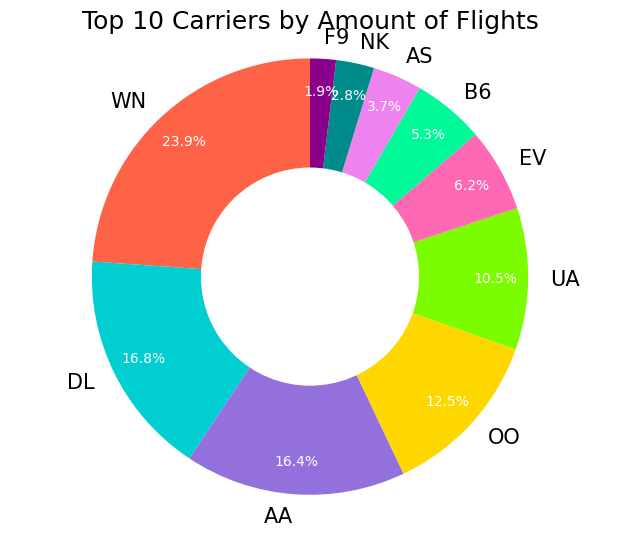

In [9]:
# Group by airline and count the occurrences
carrier_counts = airline_delays.groupby('OP_CARRIER').size().compute().reset_index()
carrier_counts.columns = ['Carrier', 'count']

# Sort the carrier counts in descending order and select the top 10
top_10 = carrier_counts.sort_values('count', ascending=False).head(10)

# Create a pie chart
carriers = top_10['Carrier'].tolist()
counts = top_10['count'].tolist()

# Define a custom list of colors
custom_colors = ['#FF6347', '#00CED1', '#9370DB', '#FFD700', '#7CFC00', '#FF69B4', '#00FA9A', '#EE82EE', '#008B8B', '#8B008B']

fig, ax = plt.subplots(figsize=(8, 6))
wedges, texts, autotexts = ax.pie(counts, labels=carriers, autopct='%1.1f%%', startangle=90,
                                  pctdistance=0.85, textprops=dict(size=10, color='black'),
                                  colors=custom_colors)

# Adjust aspect ratio
ax.axis('equal')

# Add a title
ax.set_title('Top 10 Carriers by Amount of Flights', size=18)

# Create a circle at the center for a better visualization
center_circle = plt.Circle((0, 0), 0.5, fc='white')
ax.add_artist(center_circle)

# Adjust the position of the text labels
for text in texts:
    text.set_fontsize(15)
    text.set_color('black')

for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color('white')

# Adjust spacing between the pie and text labels
plt.gcf().subplots_adjust(left=0.15, bottom=0.1, right=0.9, top=0.9)

plt.show()

In [10]:
# Filter rows where CANCELLATION_CODE is not null
airline_delays_filtered = airline_delays[airline_delays['CANCELLATION_CODE'].notnull()]

# Encode the CANCELLATION_CODE column
airline_delays_filtered['CANCELLATION_CODE'] = airline_delays_filtered['CANCELLATION_CODE'].replace({
    'A': 'By carrier',
    'B': 'Due to weather',
    'C': 'By national air system',
    'D': 'For security'
})

# Count the number of cancellations per code/reason
cancellation_counts = airline_delays_filtered.groupby('CANCELLATION_CODE').size().compute().reset_index()
cancellation_counts.columns = ['CANCELLATION_CODE', 'count']

# Rename cancellation code values
cancellation_counts['CANCELLATION_CODE'] = cancellation_counts['CANCELLATION_CODE'].replace({
    'A': 'By carrier',
    'B': 'Due to weather',
    'C': 'By national air system',
    'D': 'For security'
})

# Rename the column
cancellation_counts = cancellation_counts.rename(columns={'CANCELLATION_CODE': 'Reason'})

# Convert to Pandas DataFrame for visualization
cancellation_reasons = pd.DataFrame(cancellation_counts)

# Visualization of cancellation reasons
chart = alt.Chart(cancellation_reasons).mark_arc(outerRadius=180, innerRadius=50).encode(
    theta=alt.Theta(field="count", type="quantitative", stack=True),
    color=alt.Color('Reason:N', scale=alt.Scale(scheme='category20'), legend=None),
).properties(
    title='Reasons for flight cancellations',
    width=600,
    height=300
)

pie = chart.mark_arc(outerRadius=250)
value_text = pie.mark_text(radius=220, size=15).encode(text=alt.Text('count:Q'))

pie2 = chart.mark_arc(outerRadius=150)
text = pie2.mark_text(radius=120, size=15).encode(
    text=alt.Text('Reason:N'),
    color=alt.value("#ffffff")
)

final_chart = (chart + text + value_text).configure_view(
    strokeWidth=0
).configure_title(
    fontSize=18
)

# Display the chart
final_chart.display()

alt.LayerChart(...)

NEW TRY

In [16]:
# Split the data into features and target
X = airline_delays.drop('ARR_DELAY', axis=1)
y = airline_delays['ARR_DELAY']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [18]:
# Train the Linear Regression model
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

# Predict and evaluate
y_pred = linear_regression.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Optionally, shut down the Dask client after processing
# client.close()

2024-06-03 22:28:15,227 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:59881 (pid=22276) exceeded 95% memory budget. Restarting...
2024-06-03 22:28:15,352 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:59881 (pid=22276) is slow to terminate; trying again
2024-06-03 22:28:15,368 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:59881' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('repartitiontomore-abab23e1a9ce12e76a2ef716d60c9baf', 377), ('getitem-fused-getitem-cbf68327cd3cde0c894913b5567a1e43', 1), ('repartitiontomore-abab23e1a9ce12e76a2ef716d60c9baf', 386), ('getitem-fused-getitem-cbf68327cd3cde0c894913b5567a1e43', 10), ('getitem-fused-getitem-cbf68327cd3cde0c894913b5567a1e43', 19), ('getitem-fused-getitem-cbf68327cd3cde0c894913b5567a1e43', 28), ('repartitiontomore-abab23e1a9ce12e76a2ef716d60c9baf', 215), ('repartitiontomore-abab23e1a9ce12e76a2ef716d60c9baf', 224), ('repartitiontomore-abab23

KeyboardInterrupt: 

OLD VERSION

In [14]:
# # Encode the CANCELLATION_CODE column
# label_encoder = LabelEncoder()
# encoded_cancellation_code = label_encoder.fit_transform(airline_delays['CANCELLATION_CODE'])

# # Determine the number of partitions of airline_delays
# num_partitions_airline_delays = airline_delays.npartitions

# # Determine the number of partitions needed for encoded_cancellation_code_dask
# num_partitions_encoded_cancellation_code_dask = num_partitions_airline_delays

# # Calculate the chunk size
# chunk_size = encoded_cancellation_code.shape[0] // num_partitions_encoded_cancellation_code_dask

# # Create a new Dask DataFrame with the encoded values
# encoded_cancellation_code_dask = da.from_array(encoded_cancellation_code, chunks=(chunk_size,))
# airline_delays = airline_delays.assign(CANCELLATION_CODE_ENCODED=encoded_cancellation_code_dask)

# Compute the filtered DataFrame to get a Pandas DataFrame
# airline_delays_df = airline_delays.compute()

# Define features and target
X = airline_delays.drop(columns=['CANCELLATION_CODE'])
y = airline_delays['CANCELLATION_CODE']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot feature importances
feature_importances = pd.Series(rf_classifier.feature_importances_, index=X.columns)
plt.figure(figsize=(12, 8))
feature_importances.nlargest(20).plot(kind='barh')
plt.title('Top 20 Feature Importances')
plt.show()


c:\Users\Max\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask_ml\model_selection\_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(
2024-05-27 20:29:19,885 - distributed.scheduler - ERROR - Task ('repartitiontofewer-9a02e397f855781a5a3079ee4ced5eb0', 0) has 4.91 GiB worth of input dependencies, but worker tcp://127.0.0.1:57094 has memory_limit set to 3.94 GiB.


MemoryError: Task ('repartitiontofewer-9a02e397f855781a5a3079ee4ced5eb0', 0) has 4.91 GiB worth of input dependencies, but worker tcp://127.0.0.1:57094 has memory_limit set to 3.94 GiB.

2024-05-28 00:38:16,568 - distributed.scheduler - WARNING - Worker failed to heartbeat for 13427s; attempting restart: <WorkerState 'tcp://127.0.0.1:57092', name: 3, status: running, memory: 0, processing: 0>
2024-05-28 00:38:16,569 - distributed.scheduler - WARNING - Worker failed to heartbeat for 13427s; attempting restart: <WorkerState 'tcp://127.0.0.1:57093', name: 1, status: running, memory: 0, processing: 0>
2024-05-28 00:38:16,569 - distributed.scheduler - WARNING - Worker failed to heartbeat for 13427s; attempting restart: <WorkerState 'tcp://127.0.0.1:57095', name: 0, status: running, memory: 0, processing: 0>
2024-05-28 00:38:19,285 - distributed.nanny - WARNING - Restarting worker
2024-05-28 00:38:19,528 - distributed.nanny - WARNING - Restarting worker
2024-05-28 00:38:19,594 - distributed.nanny - WARNING - Restarting worker


In [6]:
# Define categorical columns
categorical_columns = ['OP_CARRIER', 'ORIGIN', 'DEST', 'CANCELLATION_CODE']

# Define preprocessing steps with LabelEncoder for each categorical column
label_encoders = {col: LabelEncoder() for col in categorical_columns}

# Apply LabelEncoder to each chunk of the data
for col in categorical_columns:
    airline_delays[col] = airline_delays[col].map_partitions(
        lambda x: label_encoders[col].fit_transform(x), meta=('x', 'float64')
    )

In [7]:
# Encode the CANCELLATION_CODE column
label_encoder = LabelEncoder()
encoded_cancellation_code = label_encoder.fit_transform(airline_delays_filtered['CANCELLATION_CODE'])
airline_delays_filtered['CANCELLATION_CODE_ENCODED'] = encoded_cancellation_code

# Compute the filtered DataFrame to get a Pandas DataFrame
airline_delays_filtered_df = airline_delays_filtered.compute()

# Define features and target
X = airline_delays.drop(columns=['CANCELLATION_CODE'])
y = airline_delays['CANCELLATION_CODE']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Initialize and train the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot feature importances
feature_importances = pd.Series(rf_classifier.feature_importances_, index=X.columns)
plt.figure(figsize=(12, 8))
feature_importances.nlargest(20).plot(kind='barh')
plt.title('Top 20 Feature Importances')
plt.show()

NameError: name 'airline_delays_filtered' is not defined

In [8]:
# Define features and target
X = airline_delays.drop(columns=['CANCELLATION_CODE'])  # Features
y = airline_delays['CANCELLATION_CODE']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [9]:
# Define categorical columns
categorical_columns = ['OP_CARRIER', 'ORIGIN', 'DEST']

# Define preprocessing steps with LabelEncoder for each categorical column
label_encoders = {col: LabelEncoder() for col in categorical_columns}

# Apply LabelEncoder to each chunk of the data
for col in categorical_columns:
    airline_delays[col] = airline_delays[col].map_partitions(lambda x: label_encoders[col].fit_transform(x), meta=('x', 'float64'))

In [10]:
# Train the Random Forest classifier
clf = XGBClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

2024-06-02 15:28:05,819 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:62392 (pid=20448) exceeded 95% memory budget. Restarting...
2024-06-02 15:28:06,260 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:62392 (pid=20448) is slow to terminate; trying again
2024-06-02 15:28:06,722 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:62392 (pid=20448) is slow to terminate; trying again
2024-06-02 15:28:07,002 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:62392 (pid=20448) is slow to terminate; trying again
2024-06-02 15:28:07,078 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:62392 (pid=20448) is slow to terminate; trying again
2024-06-02 15:28:07,253 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:62392' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('getitem-fused-_random_split_take-df980032caa599aabdcc70171bfb5f13', 3), ('getitem-fused-_random_split_take

In [21]:
# Define categorical columns
categorical_columns = ['OP_CARRIER', 'ORIGIN', 'DEST', 'CANCELLATION_CODE']

# Define preprocessing steps with LabelEncoder for each categorical column
label_encoders = {col: LabelEncoder() for col in categorical_columns}

# Apply LabelEncoder to each chunk of the data
for col in categorical_columns:
    airline_delays[col] = airline_delays[col].map_partitions(
        lambda x: label_encoders[col].fit_transform(x), meta=('x', 'float64')
    )

# Define features and target
X = airline_delays.drop(columns=['CANCELLATION_CODE'])
y = airline_delays['CANCELLATION_CODE']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

In [37]:
# Train the XGBoost classifier
clf = XGBClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification report
print(classification_report(y_test, y_pred))

# Close the Dask client if it was opened
if 'client' in locals():
    client.close()

TypeError: can not initialize DMatrix from DataFrame

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification report
print(classification_report(y_test, y_pred))